## Overview

This notebook assumes that `generate_all_reconstructions.py` has been run, and the reconstructions are stored in `./outputs/`.

[Test](#flow-distributions)

In [167]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import genextreme, pearson3
from scipy.optimize import curve_fit
from scipy.stats import genextreme as gev
from scipy.stats import pearson3
from sklearn.preprocessing import StandardScaler
import spei as si

from utils.data_processing import extract_realization_from_hdf5
from utils.drought_plots import plot_ssi

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, obs_site_matches
from pywrdrb.utils.constants import cms_to_mgd

In [168]:
def aggregate_node_flows(df):
    for node, sites in obs_pub_site_matches.items():
        if sites:
            df.loc[:,node] = df.loc[:, sites].sum(axis=1)    
    df['NYC Total']= df.loc[:,['cannonsville', 'pepacton', 'neversink']].sum(axis=1)
    return df

In [169]:
# Load different reconstruction variations
Q_reconst = {}
for fdc_source in ['nhmv10', 'nwmv21']:
    Q_reconst[fdc_source]= {}
    # Non NYC-scaled
    df = pd.read_csv(f'./outputs/historic_reconstruction_daily_{fdc_source}_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
    Q_reconst[fdc_source]['unscaled'] = aggregate_node_flows(df)
    
    # NYC-scaled
    df = pd.read_csv(f'./outputs/historic_reconstruction_daily_{fdc_source}_NYCscaled_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
    Q_reconst[fdc_source]['scaled'] = aggregate_node_flows(df)


    # Load ensemble flows
    n_realizations= 30
    ensemble_filename= f'./outputs/ensembles/historic_reconstruction_daily_{fdc_source}_ensemble_mgd.hdf5'
    Q_reconst[fdc_source]['ensemble'] = {}

    for i in range(n_realizations):
        df = extract_realization_from_hdf5(ensemble_filename, realization=i+1)
        
        Q_reconst[fdc_source]['ensemble'][f'realization_{i}']= aggregate_node_flows(df)

# Load historic observations
Q_obs = pd.read_csv('./outputs/streamflow_daily_usgs_1950_2022_cms.csv', sep=',', index_col=0, parse_dates=True)*cms_to_mgd


## Visual overlay

Quick visual of all reconstructions overlaid on one another for nodes of interest.

In [128]:
reconst_colordict = {'nwmv21':{'scaled': 'brown',
                               'unscaled':'tomato',
                               'ensemble':'pink'},
                     'nhmv10':{'scaled':'navy',
                               'unscaled': 'steelblue',
                               'ensemble': 'powderblue'}}

reconst_lsdict = {'scaled': 'dashed',
                  'unscaled':'solid'}

In [171]:

def plot_all_reconstructions(Q_r, plot_node,  
                             t_start, t_end,
                             plot_type='timeseries'):
    fig, ax= plt.subplots(figsize=(7,5), dpi=200)

    fdc_quantiles= np.linspace(0.00001,0.99999,200)

    consider_datasets=['unscaled', 'scaled'] if plot_node in ['cannonsville', 'pepacton', 'NYC Total'] else ['unscaled']


    for fdc_source in ['nhmv10', 'nwmv21']:
        if plot_node not in ['cannonsville', 'pepacton','NYC Total']:
            
            for i in range(n_realizations):            
                Q_hr= Q_reconst[fdc_source]['ensemble'][f'realization_{i}']
                c = reconst_colordict[fdc_source]['ensemble']
                
                if plot_type == 'timeseries':
                    if i == 0:
                        ax.plot(Q_hr.loc[t_start:t_end, plot_node], color=c, alpha=0.4, label= f'{fdc_source} QPPQ sampled traces')
                    else:
                        ax.plot(Q_hr.loc[t_start:t_end, plot_node], color=c, alpha=0.5, lw=0.7, zorder=1)
                        
                elif plot_type == 'fdc':
                    
                    fdc_vals= np.quantile(Q_hr[plot_node].values.flatten(), fdc_quantiles)
                    ax.plot(fdc_quantiles, fdc_vals, color=c, alpha=0.25)

        # Run different single-trace versions
        for s in consider_datasets:
            Q_hr= Q_reconst[fdc_source][s]
            c = reconst_colordict[fdc_source][s]
            
            if plot_type == 'timeseries':
                ax.plot(Q_hr.loc[t_start:t_end, plot_node], color=c, label= f'{fdc_source} based HR {s}', 
                        alpha=0.9, ls=reconst_lsdict[s], lw=1, zorder=3)
            elif plot_type == 'fdc':
                fdc_vals= np.quantile(Q_hr[plot_node].values.flatten(), fdc_quantiles)
                ax.plot(fdc_quantiles, fdc_vals, color=c, label= f'{fdc_source} based HR {s}')
        
    # If a obs gauge is included, add that
    if obs_site_matches[plot_node]:
        ax.plot(Q_obs.loc[t_start:t_end, [f'USGS-{s}' for s in obs_site_matches[plot_node]]].sum(axis=1),
                color = 'black', lw=1, ls =':', 
                label = 'Observed Gauge Flow', zorder=5)
            
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (MGD)')
    ax.set_yscale('log')
    h, l = ax.get_legend_handles_labels()
    legend= ax.legend(h,l,loc='lower center', bbox_to_anchor=(0.5, -0.55), ncol=2)
    plt.title(f'Reconstructed naturalized flows at: {plot_node}')
    plt.tight_layout()
    plt.savefig(f'./figures/hist_reconst_all_{plot_node}.png', dpi=200)
    return


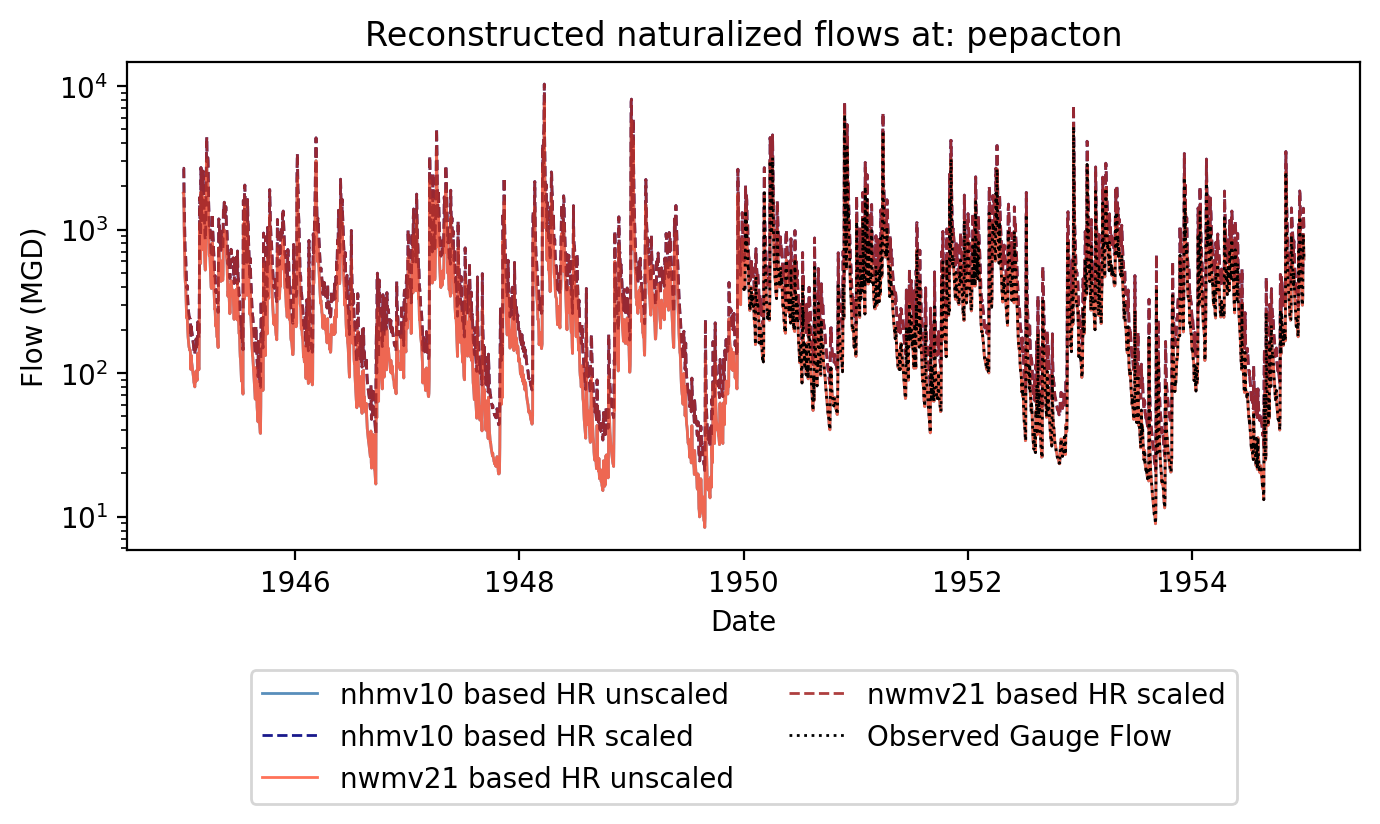

In [172]:
plot_all_reconstructions(Q_reconst, 'pepacton', t_start='1945-01-01', t_end='1955-01-01')

In [177]:
import h5py
def extract_realization_from_hdf5(hdf5_file, key_val):
    """_summary_

    Args:
        hdf5_file (str): The filename for the hdf5 file
        realization (_type_): Integer realization index

    Returns:
        pandas.DataFrame: A DataFrame containing the realization
    """
    with h5py.File(hdf5_file, 'r') as f:
        realization_group = f[key_val]
        
        # Extract column labels
        column_labels = realization_group.attrs['column_labels']
        
        # Extract timeseries data for each location
        data = {}
        for label in column_labels:
            dataset = realization_group[label]
            data[label] = dataset[:]
        
        # Get date indices
        dates = realization_group['date'][:].tolist()
        # dates = pd.to_datetime([d[1:] for d in dates])
        
    # Combine into dataframe
    df = pd.DataFrame(data, index = dates)
    df.index = pd.to_datetime(df.index.astype(str))
    return df

In [196]:

catch_ensemble_filename= f'./outputs/catchment_inflow_ensemble.hdf5'
Q_catch = {}
use_node='delLordville'
Q_catch[f'delTrenton'] = extract_realization_from_hdf5(catch_ensemble_filename, key_val='delTrenton')
Q_catch[f'delMontague'] = extract_realization_from_hdf5(catch_ensemble_filename, key_val='delMontague')
Q_catch[use_node] = extract_realization_from_hdf5(catch_ensemble_filename, key_val=use_node)

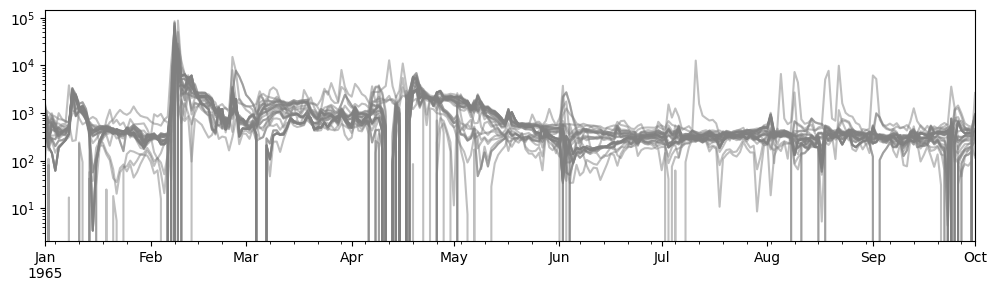

In [197]:
fig,ax = plt.subplots(figsize=(12,3))
Q_catch[use_node].loc['1965-01-01':'1965-10-01',:].plot(ax=ax,color='grey', alpha=0.5, legend=False)
plt.yscale('log')

